# Time Series Classification

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from tslearn.utils import to_time_series_dataset, save_time_series_txt, load_time_series_txt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import pickle

In [2]:
data_path = '/home/mattiapggioli/lyrics2ts/data/classification/pp-rc/sbert/'
truncate=100
max_iter = 2000
paa_window_size = None
undersampling = None

In [3]:
ts = load_time_series_txt(f'{data_path}/ts.txt')

In [4]:
ts.shape

(24000, 130, 1)

In [5]:
with open(f'{data_path}/y_class.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)

In [6]:
with open(f'{data_path}/X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)

In [7]:
X.shape

(24000, 384)

In [8]:
set(y)

{'pop', 'rock'}

In [9]:
ts_train, ts_test, y_train, y_test = train_test_split(ts, y, test_size=0.20, random_state=42)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
random.choice(ts_train)

array([[-3.89640169e-01],
       [-1.11372636e+00],
       [-1.11606015e+00],
       [ 1.07142410e-01],
       [ 9.09976069e-01],
       [-7.56652205e-01],
       [ 8.77988497e-01],
       [-6.77124513e-01],
       [-1.05611830e+00],
       [ 9.57621670e-01],
       [ 1.48331486e+00],
       [ 2.24691510e+00],
       [ 1.93815680e+00],
       [ 7.54681752e-01],
       [ 1.28207011e+00],
       [ 2.41091556e+00],
       [ 2.00717469e+00],
       [ 6.62401921e-01],
       [ 5.68369858e-01],
       [ 2.69482707e-01],
       [-8.97606568e-01],
       [-1.36598796e+00],
       [ 8.63738287e-04],
       [ 9.57621670e-01],
       [ 1.48331486e+00],
       [ 2.24691510e+00],
       [ 1.93815680e+00],
       [ 1.31675576e-01],
       [-6.37456735e-01],
       [-8.11714728e-01],
       [ 7.24943906e-01],
       [-1.65813796e+00],
       [-5.45685281e-01],
       [-1.62064671e+00],
       [-3.46353613e-01],
       [-5.55156746e-02],
       [-1.71930326e+00],
       [ 7.24943906e-01],
       [-1.0

<AxesSubplot:ylabel='Count'>

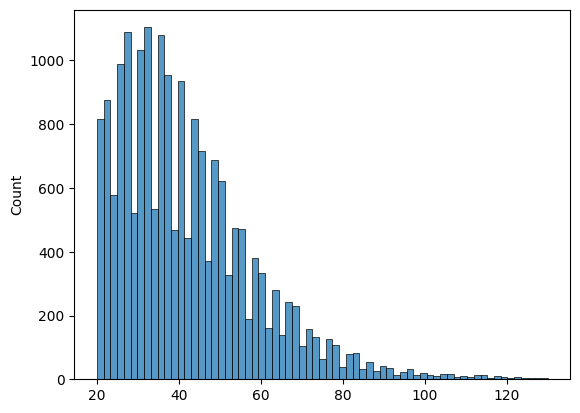

In [12]:
sns.histplot([t[~np.any(np.isnan(t), axis=1)].shape[0] for t in ts_train])

In [13]:
ts_train = ts_train[:, :truncate, :]
ts_test = ts_test[:, :truncate, :]

In [14]:
mean_arr = np.nanmean(ts_train, axis=1, keepdims=True)
nan_indices = np.isnan(ts_train)
ts_train[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

mean_arr = np.nanmean(ts_test, axis=1, keepdims=True)
nan_indices = np.isnan(ts_test)
ts_test[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

In [15]:
np.count_nonzero(np.isnan(X_train))

0

In [16]:
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

In [17]:
save_time_series_txt(f'{data_path}/ts_train.txt', ts_train)
save_time_series_txt(f'{data_path}/ts_test.txt', ts_test)

In [18]:
with open(f'{data_path}/X_train.npy', 'wb') as f:
    np.save(f, X_train, allow_pickle=True)

with open(f'{data_path}/X_test.npy', 'wb') as f:
    np.save(f, X_test, allow_pickle=True)

In [19]:
with open(f'{data_path}/y_train.npy', 'wb') as f:
    np.save(f, y_train, allow_pickle=True)

with open(f'{data_path}/y_test.npy', 'wb') as f:
    np.save(f, y_test, allow_pickle=True)

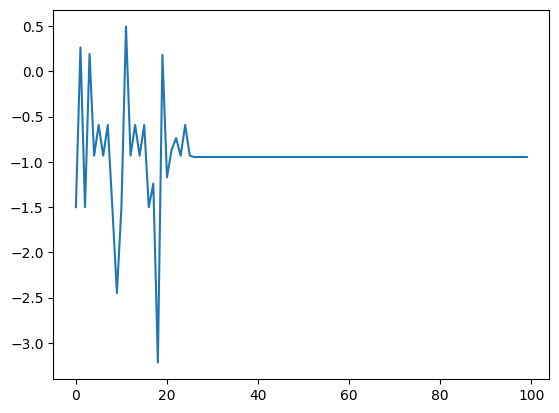

In [20]:
plt.plot(random.choice(ts_train))

In [29]:
# Parameters that require knowing if it's binary or multiclass (LightGBM, metrics)
if len(set(y)) == 2:
    avg_par = 'macro'
    obj_par = 'binary'
elif len(set(y)) > 2:
    avg_par = 'macro'
    obj_par = 'multiclass'

## Classification

In [31]:
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier

In [32]:
metrics_data = {}

### Baseline: global features (No Time Series)

In [33]:
metrics_data['Global'] = {}

**Decision Tree**

In [34]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [35]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.58      0.60      0.59      2391
        rock       0.59      0.57      0.58      2409

    accuracy                           0.58      4800
   macro avg       0.58      0.58      0.58      4800
weighted avg       0.58      0.58      0.58      4800



In [36]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [37]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.65      0.67      0.66      2391
        rock       0.66      0.65      0.66      2409

    accuracy                           0.66      4800
   macro avg       0.66      0.66      0.66      4800
weighted avg       0.66      0.66      0.66      4800



In [39]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [40]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='binary')

In [41]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.67      0.69      0.68      2391
        rock       0.68      0.66      0.67      2409

    accuracy                           0.68      4800
   macro avg       0.68      0.68      0.68      4800
weighted avg       0.68      0.68      0.68      4800



In [42]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

### Time Series Classification

#### Learning Shapelets

In [34]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict

2023-03-08 11:11:37.161348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 11:11:37.324604: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 11:11:37.324626: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 11:11:37.967701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [35]:
n_ts, ts_sz, _ = ts_train.shape
n_classes = len(set(y_train))

In [36]:
# Set the number of shapelets per size as done in the original paper
g_shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                         ts_sz=ts_sz,
                                                         n_classes=n_classes,
                                                         l=0.1,
                                                         r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', g_shapelet_sizes)

n_ts 1420
ts_sz 100
n_classes 6
shapelet_sizes {10: 5}


In [37]:
shapelet_sizes = {}
for key in g_shapelet_sizes:
    shapelet_sizes[key] = g_shapelet_sizes[key]
    shapelet_sizes[key*2] = g_shapelet_sizes[key]
    shapelet_sizes[key//2] = g_shapelet_sizes[key]
shapelet_sizes

{10: 5, 20: 5, 5: 5}

In [39]:
model = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                          optimizer="adam", 
                          weight_regularizer=.01, 
                          max_iter=max_iter, verbose=0, random_state=42)

In [ ]:
%%time
model.fit(ts_train, y_train)

2023-03-08 11:13:04.117606: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 11:13:04.117630: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 11:13:04.117649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mattiapggioli-ThinkPad-E595): /proc/driver/nvidia/version does not exist
2023-03-08 11:13:04.118173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
model.to_pickle(f'{data_path}/shapelets.pkl')

#### Shapelet-Based Classification

In [42]:
metrics_data['Shapelets'] = {}

In [43]:
X_train = model.transform(ts_train)
X_test = model.transform(ts_test)

In [44]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,6.662282,5.523741,3.292470,7.422489,5.888717,2.957287,5.854249,3.231288,3.279649,2.714551,2.760746,3.296390,6.561180,5.379394,43.399841,5.470015,5.497833,6.862443
1,6.517953,4.915958,3.294261,6.735422,4.818554,2.667261,6.132645,3.418318,3.528390,2.775469,2.712259,3.544681,7.244728,5.008254,43.848076,5.171350,4.824230,7.269975
2,7.037992,5.687197,4.106562,8.451282,6.169182,2.983976,6.435407,3.874899,3.526426,2.745763,2.858178,3.521083,7.220769,5.694877,44.647018,5.762385,5.919614,7.361225
3,6.392230,5.218866,3.809686,8.012120,5.505461,2.939744,6.401866,3.562108,3.602288,2.677584,2.913071,3.543126,7.035871,5.694799,44.228088,5.788557,5.750975,7.083966
4,8.364944,5.535240,3.064540,8.931025,6.241264,2.069019,7.174678,2.877514,2.165159,1.877643,1.852118,2.119174,5.254804,7.111127,39.065598,7.077094,6.835816,5.482317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,7.428640,5.045612,2.893758,8.161864,5.929986,2.412205,6.396420,2.956687,2.980810,2.506999,2.623611,2.964911,6.420388,5.895232,41.931793,5.853682,6.111726,6.697709
7196,7.002017,5.725966,3.042786,7.139513,5.501321,2.186597,6.233046,3.243282,2.903263,2.259184,2.406770,2.901722,6.320835,5.593498,42.398281,5.799568,5.940485,6.329617
7197,7.354607,5.574260,2.895782,7.836240,6.059998,2.222797,6.688269,3.165904,2.690587,2.052405,2.087345,2.662144,5.698635,6.307705,40.853451,6.433056,6.326950,5.904438
7198,8.021232,5.047649,3.239869,8.374660,5.475948,2.394566,7.278851,3.577485,2.607295,2.053325,2.251283,2.626518,6.119936,6.378182,41.454803,6.535767,6.545374,6.115516


**Decision Tree**

In [45]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [46]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.43      0.44      0.43      2400
         rap       0.63      0.63      0.63      2376
        rock       0.47      0.45      0.46      2424

    accuracy                           0.51      7200
   macro avg       0.51      0.51      0.51      7200
weighted avg       0.51      0.51      0.51      7200



In [47]:
pickle.dump(clf, open(f'{data_path}/decision_tree.pkl', 'wb'))

In [48]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [49]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.51      0.52      0.52      2400
         rap       0.73      0.77      0.75      2376
        rock       0.57      0.54      0.55      2424

    accuracy                           0.61      7200
   macro avg       0.60      0.61      0.61      7200
weighted avg       0.60      0.61      0.61      7200



In [51]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [52]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [53]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.52      0.51      0.51      2400
         rap       0.73      0.77      0.75      2376
        rock       0.57      0.55      0.56      2424

    accuracy                           0.61      7200
   macro avg       0.61      0.61      0.61      7200
weighted avg       0.60      0.61      0.61      7200



In [54]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

#### KNN

In [21]:
X_train = ts_train.reshape((ts_train.shape[0], ts_train.shape[1]))
X_test = ts_test.reshape((ts_test.shape[0], ts_test.shape[1]))

In [22]:
X_train.shape

(28800, 100)

In [23]:
metrics_data['KNN'] = {}

NameError: name 'metrics_data' is not defined

**Euclidean Distance**

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [26]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.36      0.38      0.37      2400
         rap       0.60      0.03      0.06      2376
        rock       0.36      0.67      0.47      2424

    accuracy                           0.36      7200
   macro avg       0.44      0.36      0.30      7200
weighted avg       0.44      0.36      0.30      7200



In [43]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['Euclidean'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Dynamic Time Warping**

In [29]:
from pyts.classification import KNeighborsClassifier
from pyts.approximation import PiecewiseAggregateApproximation
from imblearn.under_sampling import ClusterCentroids
from sklearn_extra.cluster import KMedoids

In [27]:
if paa_window_size:
    paa = PiecewiseAggregateApproximation(window_size=paa_window_size)
    X_train = paa.transform(X_train)
    X_test = paa.transform(X_test)
    X_train.shape

In [30]:
if undersampling:
    total_samples = len(y_train)
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    samp_strat = dict(zip(unique_classes, np.floor(class_counts * undersampling).astype(int)))
    print(samp_strat)
    cc = ClusterCentroids(estimator=KMedoids(
        random_state=42), sampling_strategy=samp_strat, random_state=42)
    X_train, y_train = cc.fit_resample(X_train, y_train)
    X_train.shape

{'pop': 960, 'rap': 962, 'rock': 957}


/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 112 is empty! self.labels_[self.medoid_indices_[112]] may not be labeled with its corresponding cluster (112).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 138 is empty! self.labels_[self.medoid_indices_[138]] may not be labeled with its corresponding cluster (138).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 144 is empty! self.labels_[self.medoid_indices_[144]] may not be labeled with its corresponding cluster (144).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 215 is empty! self.labels_[self.medoid_indices_[215]] may not be labeled with its corresponding cluster (215).
 

In [ ]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba',  metric_params={'window_size':3})

clf.fit(X_train, y_train)

In [70]:
%%time
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

KNeighborsClassifier(metric='dtw_sakoechiba', metric_params={'window_size': 3})

In [ ]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['DTW'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

## Overall Results

In [ ]:
metrics_data = pd.DataFrame.from_dict({(i,j): metrics_data[i][j] 
                                       for i in metrics_data.keys() 
                                       for j in metrics_data[i].keys()},
                                       orient='index')

In [ ]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

In [ ]:
metrics_data

In [ ]:
metrics_data.to_csv(f'{data_path}/metrics.csv')